# 7.4.1

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
from torchvision import datasets, transforms

data_path = '~/data/data-unversioned/p1ch7/'

In [3]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=False)

In [4]:
type(cifar10)

torchvision.datasets.cifar.CIFAR10

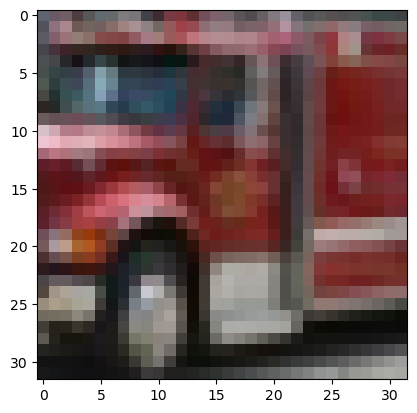

In [5]:
img, _ = cifar10[88]
plt.imshow(img)
plt.show()

## 1. 随意裁剪

In [6]:
random_crop = transforms.RandomCrop(16)
img_cropped = random_crop(img)

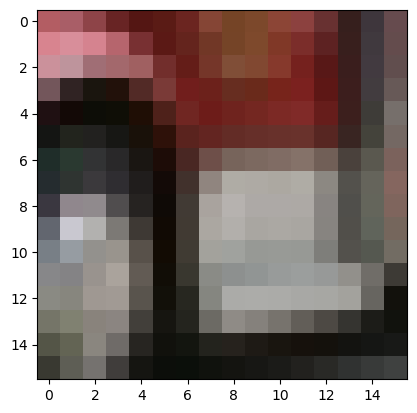

In [7]:
plt.imshow(img_cropped)
plt.show()

区别: 裁剪了喵 🐱

## 2. 二次请求

In [8]:
img_cropped_2 = random_crop(img)

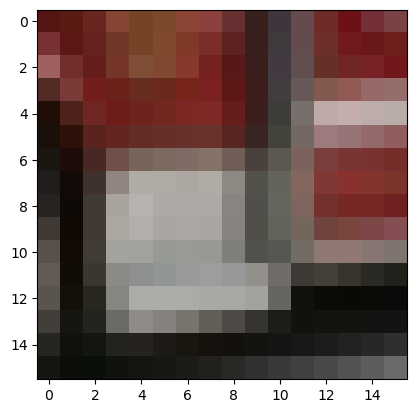

In [9]:
plt.imshow(img_cropped_2)
plt.show()

同样可以运行, 说明不是就地运行, 但是剪裁后位置有所不同

---

下面试着对以裁剪的内容进行再度裁剪

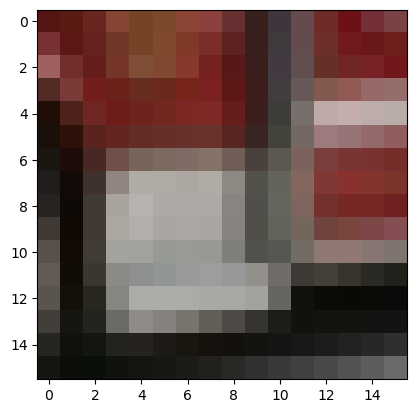

In [10]:
img_crop_twice = random_crop(img_cropped_2)
plt.imshow(img_crop_twice)
plt.show()

In [11]:
img_crop_twice == img_cropped_2

True

如上, 对已行裁剪的图像进行再度裁剪操作时, 裁剪前后图像并无区别, 也就是实际并未进行裁剪操作

## 3. 随机裁剪后训练

In [12]:
corpped_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.RandomCrop(16),
        transforms.ToTensor(),
    ]))

In [13]:
corpped_cifar10[88]

(tensor([[[0.1647, 0.1333, 0.2235, 0.3098, 0.2235, 0.1412, 0.1059, 0.2314,
           0.4353, 0.5294, 0.4196, 0.2000, 0.2157, 0.3765, 0.4353, 0.4235],
          [0.2392, 0.2392, 0.2980, 0.3176, 0.1843, 0.1137, 0.1333, 0.3020,
           0.4902, 0.5176, 0.3765, 0.2314, 0.1961, 0.3765, 0.4157, 0.4039],
          [0.3804, 0.3686, 0.3961, 0.3490, 0.3059, 0.2941, 0.3098, 0.4157,
           0.5098, 0.4157, 0.3412, 0.2275, 0.1882, 0.3686, 0.4157, 0.4275],
          [0.5765, 0.5216, 0.4706, 0.3922, 0.4039, 0.4000, 0.3647, 0.4863,
           0.5569, 0.5490, 0.4039, 0.2314, 0.2000, 0.3725, 0.4314, 0.4431],
          [0.4902, 0.4431, 0.4196, 0.4078, 0.3882, 0.3647, 0.3216, 0.4039,
           0.5412, 0.5255, 0.3804, 0.2549, 0.2078, 0.3804, 0.4353, 0.4353],
          [0.3569, 0.3451, 0.3961, 0.4078, 0.3843, 0.3843, 0.3804, 0.4353,
           0.5176, 0.4392, 0.3490, 0.2706, 0.2039, 0.3843, 0.4353, 0.4471],
          [0.3804, 0.3333, 0.3373, 0.3686, 0.4078, 0.4510, 0.4784, 0.5412,
           0.5412, 

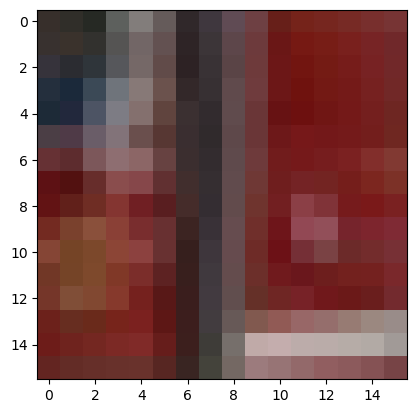

In [14]:
plt.imshow(corpped_cifar10[88][0].permute(1, 2, 0))
plt.show()

不`permute`不能打出图片, 但是为什么要`permute`?

In [15]:
imgs = torch.stack([img_t for img_t, _ in corpped_cifar10], dim=3)

imgs.shape

torch.Size([3, 16, 16, 50000])

In [16]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4909, 0.4705, 0.4343])

In [17]:
imgs.view(3, -1).std(dim=1)

tensor([0.2400, 0.2360, 0.2504])

In [18]:
type(corpped_cifar10)

torchvision.datasets.cifar.CIFAR10

In [19]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.base_dataset[index]
        return self.transform(img), label

    def __len__(self):
        return len(self.base_dataset)

# 假设cropped_cifar10是你已经裁剪过的数据集
# 现在你想要对它进行归一化处理

mean = [0.4909, 0.4705, 0.4343]
std = [0.2400, 0.2360, 0.2504]

# 创建一个transform，它会进行归一化
transform = transforms.Normalize(mean, std)

# 使用这个transform和原始数据集来创建一个新的数据集
normalized_cropped_cifar10 = TransformedDataset(corpped_cifar10, transform)

In [20]:
type(normalized_cropped_cifar10)

__main__.TransformedDataset

In [21]:
normalized_cropped_cifar10[88][0].shape

torch.Size([3, 16, 16])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


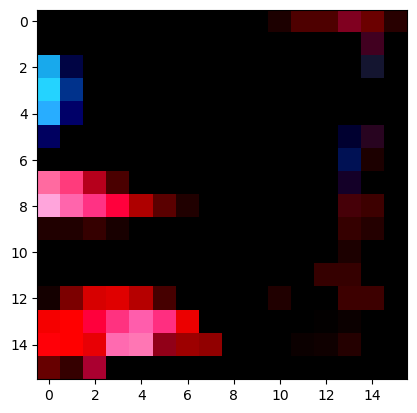

In [22]:
plt.imshow(normalized_cropped_cifar10[88][0].permute(1, 2, 0))
plt.show()

In [23]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(16),
        transforms.Normalize(mean, std)
    ]))

In [24]:
type(cifar10_val), type(normalized_cropped_cifar10)

(torchvision.datasets.cifar.CIFAR10, __main__.TransformedDataset)

In [25]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print(device)

In [26]:
# normalized_cropped_cifar10 = [(img.to(device),
#                                torch.tensor(label).to(device)) for img, label in normalized_cropped_cifar10]

In [27]:
# cifar10_val = [(img.to(device),
#                 torch.tensor(label).to(device)) for img, label in cifar10_val]

In [28]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# train_loader = torch.utils.data.DataLoader(normalized_cropped_cifar10, batch_size=64,
#                                            shuffle=True)

# model = nn.Sequential(
#             nn.Linear(768, 512),
#             nn.Tanh(),
#             nn.Linear(512, 128),
#             nn.Tanh(),
#             nn.Linear(128, 10)).to(device)

# learning_rate = 1e-1
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# loss_fn = nn.CrossEntropyLoss()

# n_epochs = 100

# for epoch in range(n_epochs):
#     for imgs, labels in train_loader:
#         outputs = model(imgs.view(imgs.shape[0], -1))
#         loss = loss_fn(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [29]:
# 先运行到 24

label_map = {0: 0, 2: 1}

In [30]:
class_names = ['airplane', 'bird']

In [31]:
cifar10 = normalized_cropped_cifar10

In [32]:
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]

cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [33]:
print(len(cifar2), len(cifar2_val))

10000 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


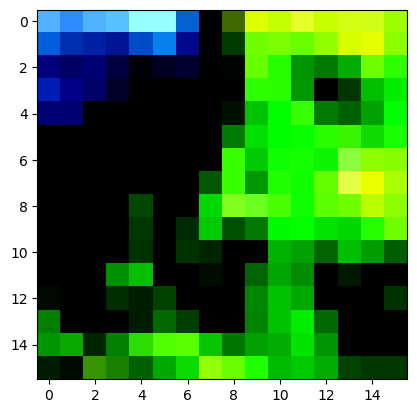

In [34]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [35]:
device = (torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))

print(device)

cuda


In [36]:
cifar2 = [(img.to(device), torch.tensor(label).to(device)) for img, label in cifar2]
cifar2_val = [(img.to(device), torch.tensor(label).to(device)) for img, label in cifar2_val]

In [37]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [38]:
16*16*3

768

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(768, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2)).to(device)

learning_rate = 1e-1

# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters())


loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.513379
Epoch: 1, Loss: 0.492196
Epoch: 2, Loss: 0.452771
Epoch: 3, Loss: 0.723273
Epoch: 4, Loss: 0.438147
Epoch: 5, Loss: 0.501265
Epoch: 6, Loss: 0.324143
Epoch: 7, Loss: 0.674234
Epoch: 8, Loss: 0.554027
Epoch: 9, Loss: 0.318265
Epoch: 10, Loss: 0.434607
Epoch: 11, Loss: 0.271820
Epoch: 12, Loss: 0.429130
Epoch: 13, Loss: 0.249718
Epoch: 14, Loss: 0.311757
Epoch: 15, Loss: 0.384667
Epoch: 16, Loss: 0.093742
Epoch: 17, Loss: 0.123439
Epoch: 18, Loss: 0.108955
Epoch: 19, Loss: 0.429305
Epoch: 20, Loss: 0.085796
Epoch: 21, Loss: 0.031663
Epoch: 22, Loss: 0.044541
Epoch: 23, Loss: 0.096550
Epoch: 24, Loss: 0.057976
Epoch: 25, Loss: 0.090345
Epoch: 26, Loss: 0.217808
Epoch: 27, Loss: 0.004327
Epoch: 28, Loss: 0.028972
Epoch: 29, Loss: 0.191089
Epoch: 30, Loss: 0.033854
Epoch: 31, Loss: 0.024298
Epoch: 32, Loss: 0.101230
Epoch: 33, Loss: 0.178992
Epoch: 34, Loss: 0.029928
Epoch: 35, Loss: 0.132706
Epoch: 36, Loss: 0.089241
Epoch: 37, Loss: 0.082053
Epoch: 38, Loss: 0.202

In [57]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.986600


In [58]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.764500


训练的结果如上, 结果应该是更差了的.